In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset                Hotel Reservations Dataset                          480KB  2023-01-04 12:50:31           7411        264  1.0              
themrityunjaypathak/most-subscribed-1000-youtube-channels        Most Subscribed 1000 Youtube Channels                28KB  2023-01-21 14:42:05           1429         51  1.0              
senapatirajesh/netflix-tv-shows-and-movies                       Latest Netflix TV shows and movies                    1MB  2023-01-14 17:03:12           2781         74  0.9411765        
ulrikthygepedersen/on

In [ ]:
! kaggle datasets download "xhlulu/140k-real-and-fake-faces"

100% 3.75G/3.75G [00:21<00:00, 103MB/s] 
100% 3.75G/3.75G [00:21<00:00, 191MB/s]


In [ ]:
! unzip -qq /content/140k-real-and-fake-faces.zip

## Imports

In [ ]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn import metrics

In [ ]:
path  = "/content/real_vs_fake/real-vs-fake/"

In [ ]:
data_dict = {"image_path":[],"img_status":[],"where":[]}

for where in os.listdir(path):
    for status in os.listdir(path + "/" + where):
        for image in glob.glob(path + where + "/" + status + "/" + "*.jpg"):
            data_dict["image_path"].append(image)
            data_dict["img_status"].append(status)
            data_dict["where"].append(where)
dataset = pd.DataFrame(dataset)

In [ ]:
df

,image_path,img_status,where
0,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid
1,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid
2,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid
3,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid
4,/content/real_vs_fake/real-vs-fake/valid/real/...,real,valid
...,...,...,...
139995,/content/real_vs_fake/real-vs-fake/test/fake/9...,fake,test
139996,/content/real_vs_fake/real-vs-fake/test/fake/Y...,fake,test
139997,/content/real_vs_fake/real-vs-fake/test/fake/C...,fake,test
139998,/content/real_vs_fake/real-vs-fake/test/fake/3...,fake,test


In [ ]:
image_generator = ImageDataGenerator()
train_dir = path + "train/"
validation_dir = path + "valid/"
test_dir = path + "test/"

In [ ]:
# Define a data generator function that will limit repetitive code, 
# as we have data pre-split into train, validation and test sets.
def get_data_generator(data_directory, class_mode, batch_size=32, resize_to=(256, 256), preprocessing_function=None):
    """Create a data generator from a directory containing images.

    Params:
    -------
    data_directory :: string  
        The path containing the image data  
    class_mode :: str  
        One of 'categorical', 'binary', 'sparse', 'input', or `None`.  
        Determines the type of label arrays that are returned:  
            - 'categorical' will be 2D one-hot encoded labels;  
            - 'binary' will be 1D binary labels;  
            - 'sparse' will be 1D integer labels;  
            - 'input' will be images identical to input images (mainly used to work with autoencoders).  
    batch_size :: int  
        Custom batch size. Default: 32  
    resize_to :: tuple  
        New image size. Default: (256, 256)  
    preprocessing_function :: function  
        The images pre-processing function to use for the data generator. Default: `None`

    Returns:
    --------
    data_generator :: keras DirectoryIterator  
        The iterator object to load the data from directory"""

    # Instantiate the generator, normalise pixel values:
    img_generator = ImageDataGenerator(rescale=1./255,
                                       preprocessing_function=preprocessing_function)

    # Generate data. Set batch size, class mode and image size.
    # Don't forget seed for reproducibility:
    data_generator = img_generator.flow_from_directory(directory=data_directory,
                                                       batch_size=batch_size,
                                                       class_mode=class_mode,
                                                       target_size=resize_to,
                                                       seed=666)

    # Return the generated data:
    return data_generator

In [ ]:
# Batch size:
BATCH_SIZE = 100

In [ ]:
# Create the training set generator:
train_generator = get_data_generator(data_directory=data_path+"train/",
                                     class_mode="binary",
                                     batch_size=BATCH_SIZE,
                                     resize_to=(150, 150),
                                     preprocessing_function=preprocess_input)
# Create the validation set generator:
val_generator = get_data_generator(data_directory=data_path+"valid/",
                                   class_mode="binary",
                                   batch_size=BATCH_SIZE,
                                   resize_to=(150, 150),
                                   preprocessing_function=preprocess_input)
# Create the test set generator:
test_generator = get_data_generator(data_directory=data_path+"test/",
                                    class_mode="binary",
                                    batch_size=1,
                                    resize_to=(150, 150),
                                    preprocessing_function=preprocess_input)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(1, activation = "sigmoid")(x) 

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
 model.compile(optimizer = Adam(), 
               loss = "binary_crossentropy",
               metrics = ["accuracy"])

# Callbacks for training management

In [ ]:
early_stop = EarlyStopping(monitor="val_accuracy", patience=3, verbose=1, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=3, min_lr=0.00001)

# Checkpoint path
checkpoint_path = "weights.h5"
# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor="val_accuracy",
                             mode="min",
                             save_freq="epoch")

# Training the model


In [ ]:
EPOCHS = 10

In [ ]:
steps_per_epoch = 100000 // BATCH_SIZE
val_steps = 20000 // BATCH_SIZE

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              validation_data = val_generator,
                              validation_steps = val_steps,
                              epochs = EPOCHS,
                              callbacks = [early_stopping, reduce_lr, checkpoint])

<ipython-input-19-45abfd7dc075>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
1000/1000 [==============================] - 391s 370ms/step - loss: 0.1614 - accuracy: 0.9353 - val_loss: 0.3474 - val_accuracy: 0.8637 - lr: 0.0010
Epoch 2/10
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0443 - accuracy: 0.9841 - val_loss: 0.2297 - val_accuracy: 0.9326 - lr: 0.0010
Epoch 3/10
1000/1000 [==============================] - 350s 349ms/step - loss: 0.0382 - accuracy: 0.9857 - val_loss: 0.0716 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 4/10
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0222 - accuracy: 0.9923 - val_loss: 0.1290 - val_accuracy: 0.9610 - lr: 0.0010
Epoch 5/10
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0163 - accuracy: 0.9940 - val_loss: 0.0487 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 6/10
1000/1000 [==============================] - 348s 348ms/step - loss: 0.0155 - accuracy: 0.9943 - val_loss: 0.3345 - val_accuracy: 0.9096 - lr: 0.0010
Epoch 7/10
1000/1000 [============

20000/20000 [==============================] - 255s 13ms/step


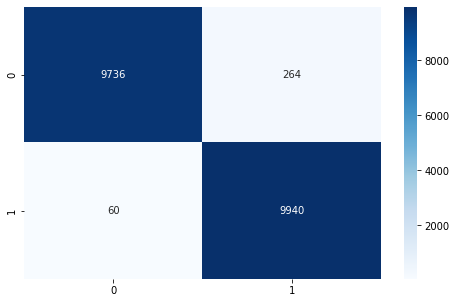

In [ ]:
y_pred = model.predict(test_generator)
y_test = test_generator.classes

plt.figure(figsize = (8, 5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot=True, fmt="d", cmap = "Blues")
plt.show()

In [ ]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.99883297
AP Score: 0.9984988643481648


In [ ]:
print(metrics.classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10000
           1       0.97      0.99      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



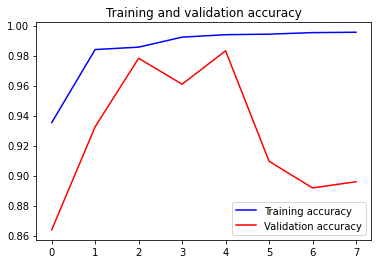

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(len(acc))

plt.plot(epochs, acc, "b", label="Training accuracy")
plt.plot(epochs, val_acc, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend(loc=0)
plt.figure()

plt.show()